<a href="https://colab.research.google.com/github/nikishkaaa/ML-Course/blob/main/HW_2_8_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [13]:
!pip install opendatasets --upgrade --quiet

In [76]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import opendatasets as od
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import joblib
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [18]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data'

In [19]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: darianikishkina
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 913kB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


In [23]:
data_dir = './bank-customer-churn-prediction-dlu'
os.listdir(data_dir)

['sample_submission.csv', 'train.csv', 'test.csv']

Area under ROC score on  dataset: 0.93%


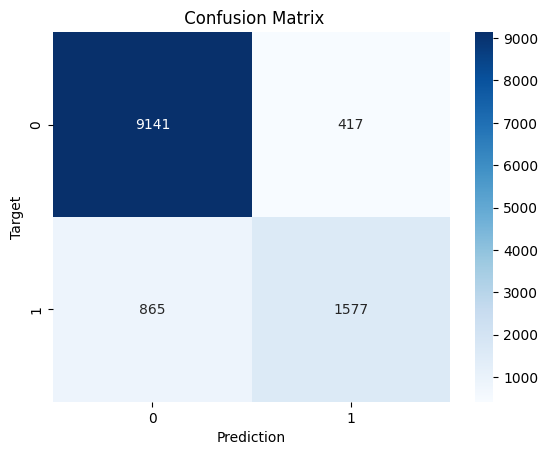

Area under ROC score on  dataset: 0.92%


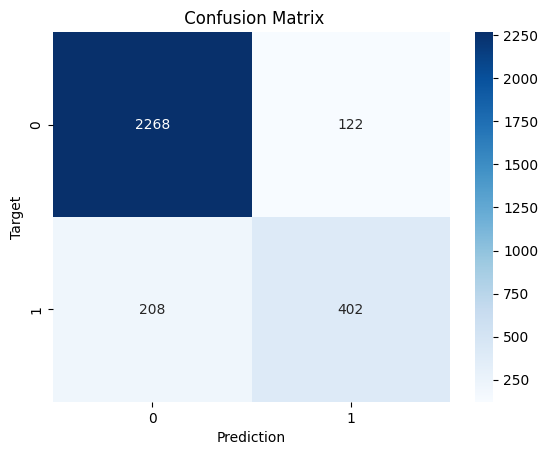

In [43]:
train_df = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv', index_col=0)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

numeric_cols = [
 'Age',
 'Balance',
 'CreditScore',
 'IsActiveMember',
 'Tenure',
 'EstimatedSalary']
categorical_cols = ['Geography', 'Gender','NumOfProducts']


# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    preds_for_matrix = model_pipeline.predict(inputs)
    confusion_matrix_ = confusion_matrix(targets, preds_for_matrix)
    plt.figure()
    sns.heatmap(confusion_matrix_, fmt='d', annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets )
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets)

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on  dataset: 0.93%


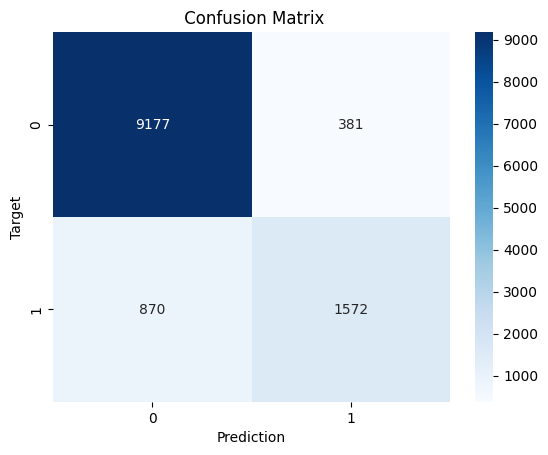

Area under ROC score on  dataset: 0.92%


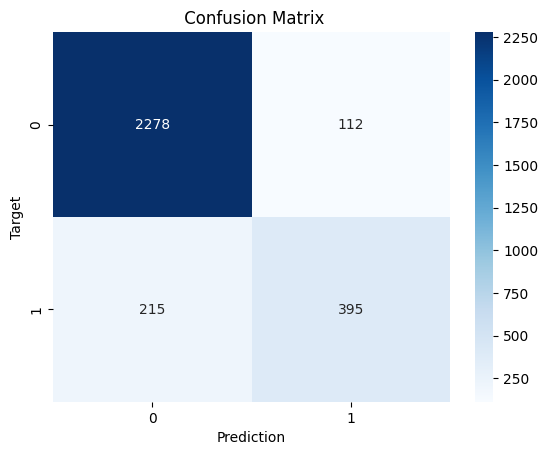

In [45]:
numeric_transformer_2 = Pipeline(steps = [
    ('polinomial',  PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

categorical_transformer_2 = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_2, numeric_cols),
        ('cat', categorical_transformer_2, categorical_cols)
    ])

polinomial_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor_2),
    ('classifier', LogisticRegression(solver='liblinear'))

])

polinomial_pipeline.fit(train_inputs, train_targets)


# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(polinomial_pipeline, train_inputs, train_targets )
val_preds = predict_and_plot(polinomial_pipeline, val_inputs, val_targets)

Висновок: Overfit + underfit не спостерігаються, так як значення метрики на трейн і вал наборах майже не відрізняються. Модель працює добре

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on  dataset: 0.93%


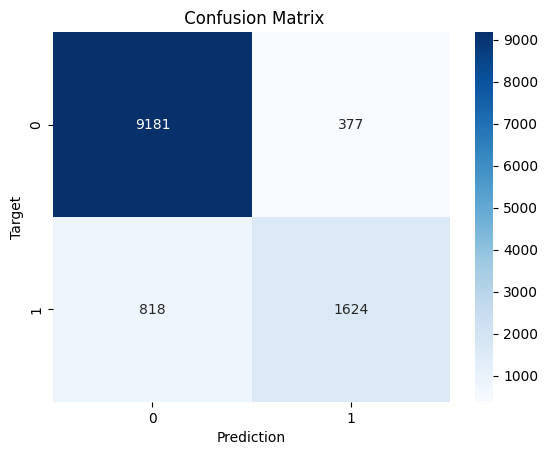

Area under ROC score on  dataset: 0.93%


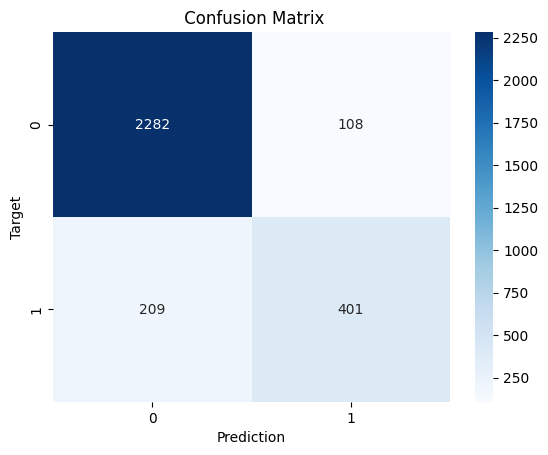

In [46]:
numeric_transformer_4 = Pipeline(steps = [
    ('polinomial',  PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

categorical_transformer_4 = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_4, numeric_cols),
        ('cat', categorical_transformer_4, categorical_cols)
    ])

polinomial_pipeline_4 = Pipeline(steps = [
    ('preprocessor', preprocessor_2),
    ('classifier', LogisticRegression(solver='liblinear'))

])

polinomial_pipeline_4.fit(train_inputs, train_targets)


# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(polinomial_pipeline_4, train_inputs, train_targets )
val_preds = predict_and_plot(polinomial_pipeline_4, val_inputs, val_targets)

In [58]:
import warnings
warnings.filterwarnings("ignore")
def predict_test(model_pipeline, inputs):
    preds = model_pipeline.predict_proba(inputs)[:, 1]
    return preds


test_raw_df = pd.read_csv('bank-customer-churn-prediction-dlu/test.csv')
test_raw_df['Exited'] = predict_test(model_pipeline, test_raw_df)
sample_submission = pd.read_csv('bank-customer-churn-prediction-dlu/sample_submission.csv')
merged_df = sample_submission.merge(test_raw_df, on='id', how='left')
merged_df['Exited'] = merged_df['Exited_y']
merged_df = merged_df[['id', 'Exited']]

In [60]:
merged_df.to_csv('submission_log_reg4.csv', index=False)

Висновок: модель з поліноміальнимі ознаками 4 степеня краще перформить для валідаційного набору даних. Overfit/underfit не спостерігаються

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [63]:
regression_data = pd.read_csv('/content/regression_data.csv')
regression_data.head(3)

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482


In [68]:
X = regression_data.drop(['target'], axis=1)
y = regression_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('polynomial', PolynomialFeatures(degree=5, include_bias=False)),
    ('classifier', LinearRegression())
])

# Тренуємо пайплайн
pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
print('Train RMSE: ', mean_squared_error(y_train, y_pred_train, squared=False))
print('Test RMSE: ', mean_squared_error(y_test, y_pred_test, squared=False))

Train RMSE:  7.080107256942845e-13
Test RMSE:  35.62805277364301


In [74]:
y_train.mean(), y_train.std()

(-6.450753928428644, 44.35003659161175)

Висновок: RMSE менше ніж стандартне відхілення, але при цьому різниця між RMSE для тренувального і тестового набору сильно відрізняються, отже модель перенавчилась

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [82]:
models = [
    Lasso(),
    Ridge(),
    ElasticNet(),
    ElasticNet(alpha = 2)
]

poly_features = PolynomialFeatures(degree=20)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)


for model in models:
  model.fit(X_train_poly, y_train)
  y_train_pred = model.predict(X_train_poly)
  y_test_pred = model.predict(X_test_poly)
  train_metrics = mean_squared_error(y_train, y_train_pred, squared=False).round(6)
  test_metrics = mean_squared_error(y_test, y_test_pred, squared=False).round(6)
  print(model, ' ', 'train RMSE= ', train_metrics, ' test RMSE = ', test_metrics)

Lasso()   train RMSE=  2.313505  test RMSE =  68.318791
Ridge()   train RMSE=  32.582352  test RMSE =  9034.946659
ElasticNet()   train RMSE=  10.159852  test RMSE =  1526.820921
ElasticNet(alpha=2)   train RMSE=  12.894555  test RMSE =  2183.776416


Висновок: жодна з моделей не генералізує, у всіх присутнє перенавчання.
Однією з причин перенавчання може бути завелика к-ть ознак, отже проведемо експеремент і зменшимо поліном з 20 ознак до 2

In [85]:
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)


for model in models:
  model.fit(X_train_poly, y_train)
  y_train_pred = model.predict(X_train_poly)
  y_test_pred = model.predict(X_test_poly)
  train_metrics = mean_squared_error(y_train, y_train_pred, squared=False).round(6)
  test_metrics = mean_squared_error(y_test, y_test_pred, squared=False).round(6)
  print(model, ' ', 'train RMSE= ', train_metrics, ' test RMSE = ', test_metrics)

Lasso()   train RMSE=  1.571223  test RMSE =  1.512621
Ridge()   train RMSE=  1.170678  test RMSE =  1.2341
ElasticNet()   train RMSE=  17.394886  test RMSE =  20.761708
ElasticNet(alpha=2)   train RMSE=  24.882126  test RMSE =  29.268378


Отже, після зменшення к-ті ознак модель працює добре, відсутнє перенавчання. Найкраща модель - Lasso
